The notebook is split into sections: we discuss different elements of setting up a Prophet model, show how to evaluate its performance and demonstrate a pipeline putting all the elements together.

* [Prophet](#section-one)
* [Trend](#section-two)
* [Seasonality](#section-three)
* [Special days](#section-four)
* [Performance evaluation](#section-five)
* [Full pipeline](#section-six)
* [Using covariates](#section-seven)
* [Neural Prophet](#section-eight)

As before, we begin by importing the required packages

In [26]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae
import warnings
import itertools
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.easter import easter
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_yearly, add_changepoints_to_plot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from neuralprophet import NeuralProphet
from data_sources import *

In [27]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category= FutureWarning)

In [28]:
# general settings
class CFG:
    data_folder = data
    img_dim1 = 15
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Prophet

While useful in practice, exponential smoothing can only handle one seasonal pattern at at time. Challenges like these led to the development of Prophet, which is a time series framework designed to work out of the box and developed by Core Data Science team at FB: https://research.facebook.com/research-areas/data-science/. The core idea is based around structural decomposition:

\begin{equation}
X_t = T_t + S_t + H_t + \epsilon_t
\end{equation}

where
* $T_t$ : trend component
* $S_t$ : seasonal component (weekly, yearly)
* $H_t$ : deterministic irregular component (holidays)
* $\epsilon_t$: noise 

For the more scientifically among the readers, the original paper describing the approach can be found here: https://peerj.com/preprints/3190/.


We will discuss the Prophet style of modeling trend, seasonality and holidays in the sections below, but first a crash intro to the theory behind the models. 

## Generalized Additive Models (GAM)

The core mathematical idea behind Prophet is the Kolmogorov-Arnold representation theorem, which states that multivariate function could be represented as sums and compositions of univariate functions:

\begin{equation} 
    {\displaystyle f({x_1, \ldots, x_n})=\sum _{q=0}^{2n}\Phi _{q}\left(\sum _{p=1}^{n}\phi _{q,p}(x_{p})\right)}
\end{equation}

The theorem has no constructive proof suitable for modeling $\implies$ simplification is necessary: 

\begin{equation}
{\displaystyle f({x_1, \ldots, x_n})=\Phi \left(\sum _{p=1}^{n}\phi _{p}(x_{p})\right)}
\end{equation}
where $\Phi$ is a smooth monotonic function. This equation gives a general representation of GAM models and a familiar variant of this approach is the class of Generalized Linear Models :

\begin{equation}
\Phi^{-1}\left[\operatorname {E}(Y)\right]=\beta _{0}+f_{1}(x_{1})+f_{2}(x_{2})+\cdots +f_{m}(x_{m}).\,\!
\end{equation}

The smooth functions in the context of Prophet are the trend, seasonal and holiday components - we can isolate each individual function and evaluate its effect in prediction, which makes such models easier to interpret. we estimate through backfitting algorithm $\rightarrow$ convergence

## The prophetic core

So how does that work in practice? We take a GAM-style decomposition as our starting point:

\begin{equation}
X_t = T(t) + S(t) + H(t) + \epsilon_t
\end{equation}

Unpacking the equation: 

* time is the only regressor

* easy accomodation of new components

* multiple seasonal patterns $\rightarrow$ extension of double exponential smoothing

* forecasting $\rightarrow$ curve fitting

* no need for regular spacing $\implies$ no NA filling

* fast fitting with backfitting algorithm https://en.wikipedia.org/wiki/Backfitting_algorithm

* probabilistic aspects - Hamiltonian Monte Carlo (which is why Windows have an extra step of Stan installation - but trust me, it's worth it)

* works in more general cases, but "designed" for daily data



Below we discuss each of the components in its own section.

<a id="section-two"></a>
# Trend model

The Prophet library implements two possible trend models.


## Linear Trend

The first, default trend model is a simple Piecewise Linear Model with a constant rate of growth. It is best suited for problems without saturating growth and takes advantage of the fact that a broad class of shapes can be approximated by a piecewise linear function.

\begin{equation}
T(t) = \left[k + a(t)^T \delta \right]t + \left[m + a(t)^T \gamma\right]
\end{equation}

By default, Prophet estimates 25 changepoints in the model, over 80pct of the dataset (those parameters can be adjusted). Changepoints are defined as changes in the trajectory, which can be esimated or provided manually - the latter is a useful option if domain knowledge is available to the analyst.


We demonstrate this functionality by using New York Times data on Covid cases: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv

<AxesSubplot:>

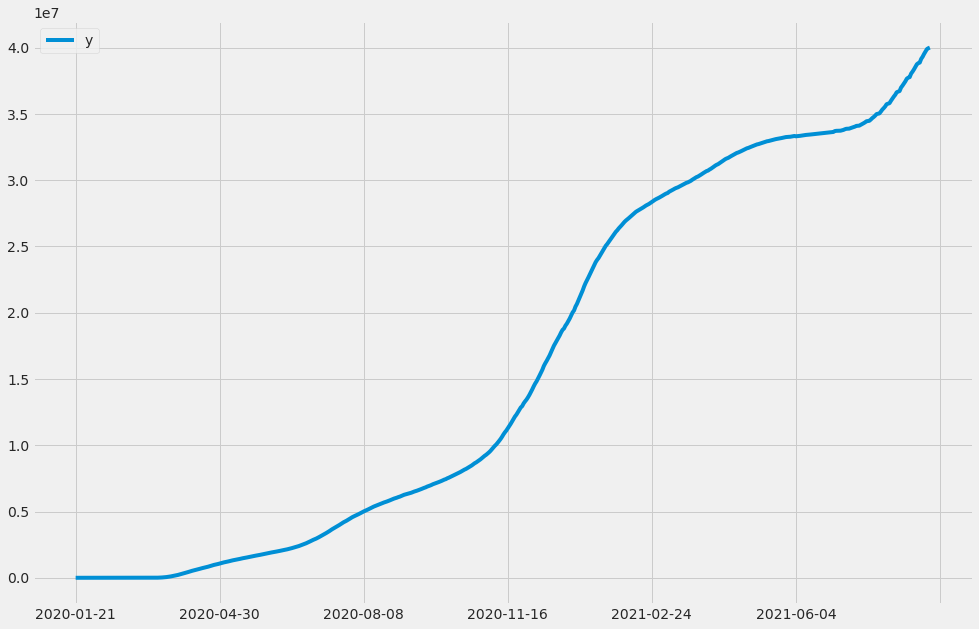

In [29]:
df = pd.read_csv(us_covid)
df.head(10)

# Prophet does have a quirk: a hardcoded format for the input time series - it must consist of a date column named 'ds' (dataframe index or an actual column) and column 'y', where the actual values of the time series are stored
xdat = df[['date', 'cases']].rename(columns={"date": "ds", "cases": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.77935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2173.8   0.000867341         461.8           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2233.54    0.00146611       227.869           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2251.58    0.00084613       241.732      0.9594      0.9594      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2255.45   0.000453475       314.398           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2263.26   0.000719739       219.176      0.4714           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

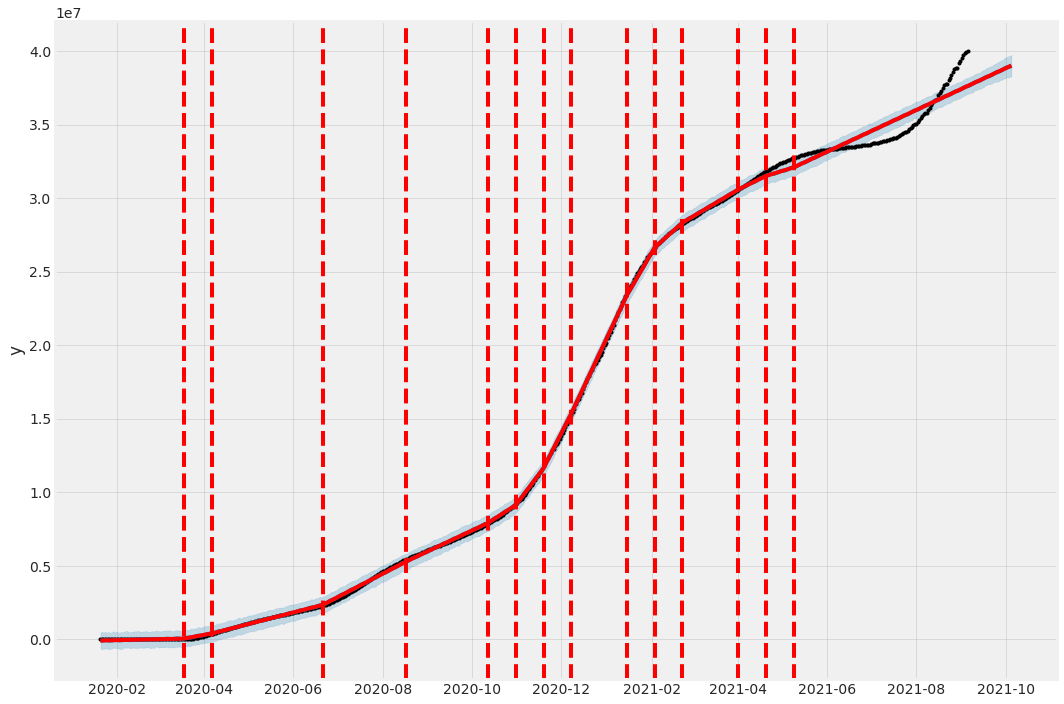

In [30]:
# automatic detection of changepoints
m = Prophet()
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)

It seems like the default settings are on the generous side when it comes to assigning changepoints - we can control this behavior by enforcing more regularization. This is achieved by shrinking the `changepoint_prior_scale` parameter:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.77935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1733.94    0.00510707        668.43           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1801.38   0.000820244       875.328           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1829.71   0.000576847       1428.06      0.5069      0.5069      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       1840.77   0.000219707       935.787   4.672e-07       0.001      533  LS failed, Hessian reset 
     399       1842.32   0.000306026       313.645           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     444       1843.85   0.000103646    

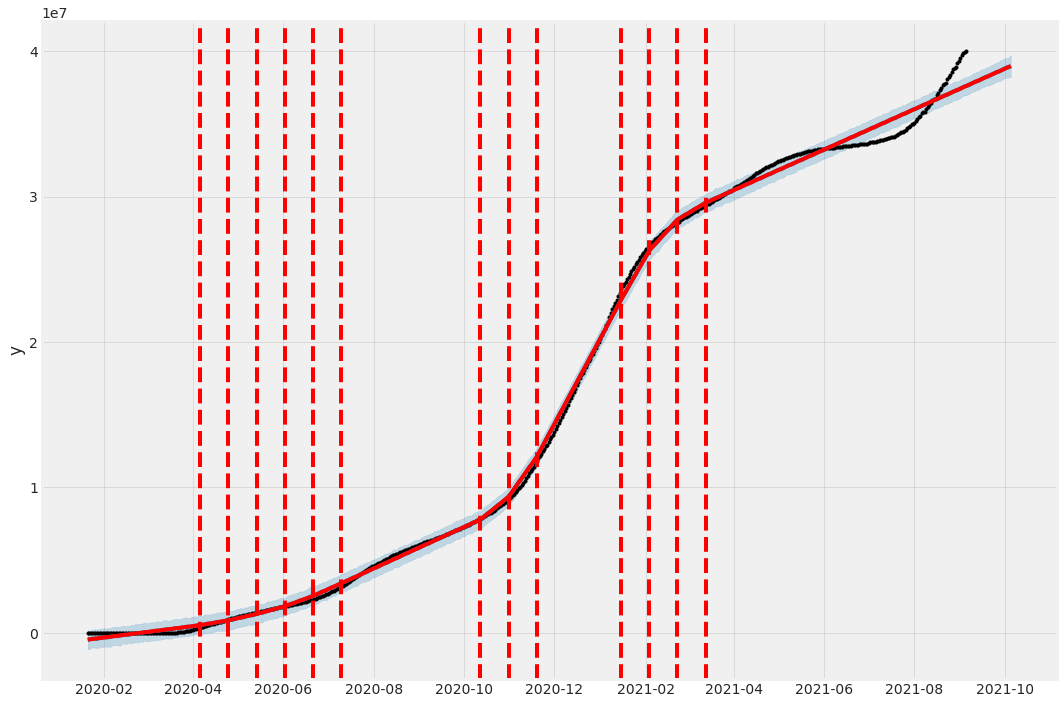

In [31]:
m = Prophet(changepoint_prior_scale = 0.01)
m.fit(xdat)
future = m.make_future_dataframe(periods= 30)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## Nonlinear growth 

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:
    
\begin{equation}
T(t) = \frac{C}{1 + exp(-k(t-m))}
\end{equation}

where $C$ is the carrying capacity (maximum value) and $k$ is the growth rate ("steepness" of the trend curve). $C$ and $k$ can be constant or time-varying. This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data.

Sticking with the theme that has dominated everybody's life from 2020, we will use data on Covid-19 cases in China.

In [32]:
df = pd.read_csv(WHO_full_data2003)
# subset the data and rename the columns to Prophet naming convention
df = df.loc[df['location'] == 'China'][['date', 'total_cases']].rename(columns={"date": "ds", "total_cases": "y"})
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

ValueError: Invalid file path or buffer object type: <class 'tuple'>

We can see the curve flatlining somewhat - in Prophet we can incorporate such knowledge into the model by setting a cap (an upper limit on the forecast value):

In [ ]:
# add the cap to the 
df['cap'] = 85000
# fit the model
m = Prophet(growth='logistic')
m.fit(df)
# prediction
future = m.make_future_dataframe(periods= 14)
future['cap'] = 85000
# plot the results
fcst = m.predict(future)
fig = m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')

The approach is symmetrics, i.e. we can limit the series from below as well (contrived as it might seem in this particular application ;-) 

In [ ]:
# set the upper & lower limit for the forecast
df['cap'] = 85000
df['floor'] = 0
# fit a model
m = Prophet(growth='logistic')
m.fit(df)
# predict
future = m.make_future_dataframe(periods= 7)
future['cap'] = 85000
future['floor'] = 0
fcst = m.predict(future)
m.plot(fcst, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')
print()

<a id="section-three"></a>
# Seasonality

When dealing with data in practical applications, it is frequently necessary to take into account multiple seasonal patterns occurring in parallel; a classic example would be data related to energy consumption: there are morning vs evening patterns (intraday), workdays vs weekend (weekly) and during the year (annual). Modeling them explicitly tends to be cumbersome (you need to add more equations in exponential smoothing or introduce dummies in ARIMA), which is one of the issues Prophet was designed to overcome. The core of the underlying logic is a the Fourier expansion:
    
\begin{equation}
    S(t) = \sum_{i=1}^N \left(a_n cos\left(\frac{2\pi i t}{P} \right) + b_n sin\left(\frac{2 \pi i t}{P} \right) \right)
\end{equation}

Unpacking this formula: 

* `sin` and `cos` function form an orthogonal basis https://en.wikipedia.org/wiki/Orthogonal_functions#Trigonometric_functions
* this means that every function can be represented as a combination as in the equation defined above - recall that in the GAM setup we treat time as the only regressor, so a time series can be viewed as a function of time $S(t)$ 
* by cutting off the expansion for a certain $N$ we can remove high frequency oscillations $\rightarrow$ low pass filter

## Frequency shenanigans

Let us briefly explore how you can specify different seasonality patterns: we will use the energy consumption data from PJM Interconnection LLC (PJM) - a regional transmission organization (RTO) in the United States. The data is available on Kaggle: https://www.kaggle.com/robikscube/hourly-energy-consumption.

In [ ]:
df = pd.read_csv(pjm_hourly_est)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head(5)

Prophet is built for univariate data, so we will pick one series. Notice that we are using hourly data, which we will progressively aggregate to lower frequencies to demonstrate the out-of-the-box functionality that Prophet provides.

In [ ]:
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))

In [ ]:
# we reduce the dataset size for speed - the only requirement while doing is to keep at least two complete cycles 
# for each seasonality we intend to fit 
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

If we are using data sampled at higher frequency than daily, a daily seasonal pattern is automatically fitted. What if we aggregate the data to daily frequency?

In [ ]:
xdat = df.resample('D', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

In [ ]:
# we proceed in a similar manner as before
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 7, freq = 'D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

The same logic applies if we downsample the data further:

In [ ]:
xdat = df.resample('M', on='Datetime').sum().reset_index()[['Datetime', 'PJME']].rename(columns={"Datetime": "ds", "PJME": "y"})
xdat['y'] /= 10^9
# we purge the leading zeros, along with the last observation - we only have a few hours of the last day in the sample => incomplete day
ix = np.where(xdat['y'] > 0)[0][0]
xdat = xdat.iloc[ix:-1]
xdat.set_index('ds').plot(xlabel = '')
print()

In [ ]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods = 12, freq = 'M')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

## Seasonality specification

Apart from deciding on which frequencies to model explicitly, we have more options to setup our Prophet model. First, there is `seasonality_mode` - additive or multiplicative:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        401.66   1.79041e-05       55.4697           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159         401.8   7.30906e-05       77.6891   1.072e-06       0.001      246  LS failed, Hessian reset 
     181       401.805   1.83883e-05       54.9427   2.747e-07       0.001      307  LS failed, Hessian reset 
     199       401.806   4.36665e-07       56.9097      0.1579           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        401.86   1.34499e-06       66.5975           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       401.861   4.08281e-08       80.1649      0.1685           1      567   
Optimization terminat

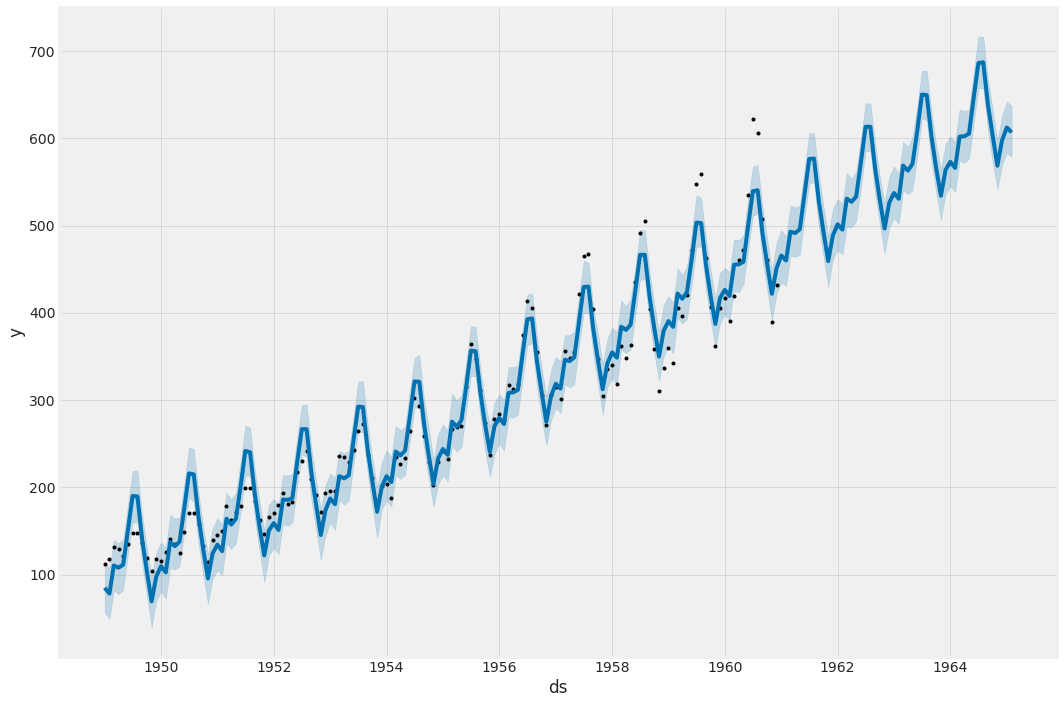

In [33]:
# import inspect ; xlist = inspect.getfullargspec(Prophet); xlist.args
df = pd.read_csv(example_air_passengers)
m = Prophet(seasonality_mode ='additive')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.449     0.0176543       240.422       0.649           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.353    0.00108498       90.0341      0.3062      0.3062      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.446   0.000140197        80.679           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       503.467   9.96247e-05       114.472   7.079e-07       0.001      451  LS failed, Hessian reset 
     359       503.486   8.82342e-09       72.6598    0.004982           1      538   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


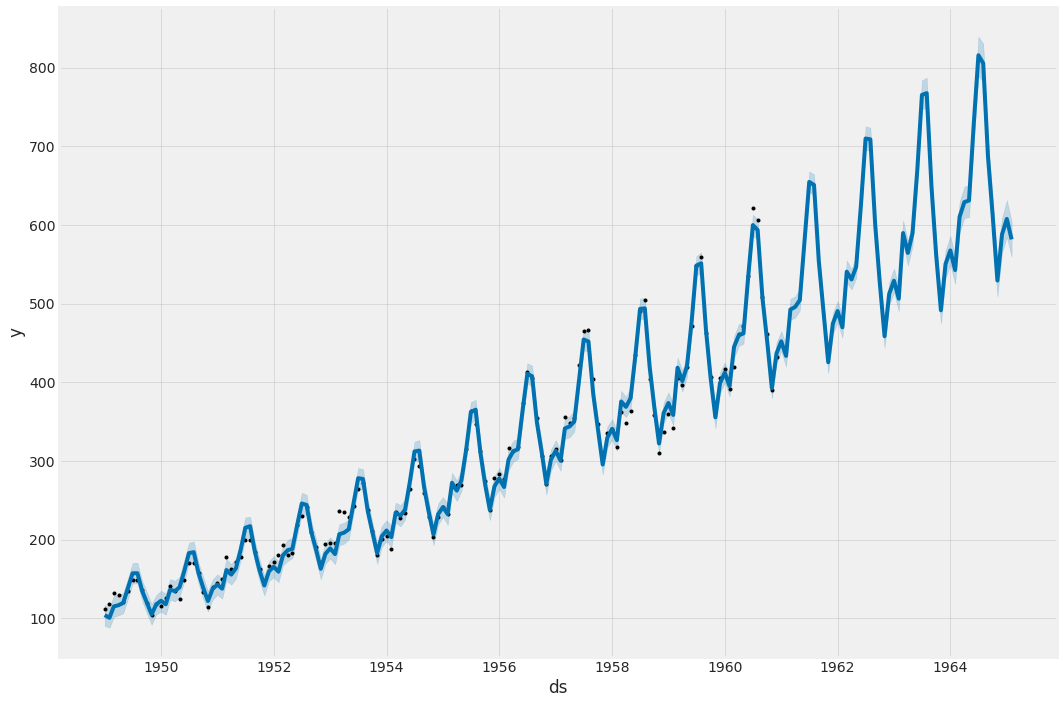

In [34]:
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Depending on the problem at hand, we might want to allow strong effects of the seasonal component on the forecast - or have it reduced. This intuition can be quantified by adjusting the `seasonality_prior_scale` argument, which imapcts the extent to which the seasonality model will fit the data (remark for those with Bayesian exposure: works pretty much the way a prior would).

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.449     0.0176543       240.422       0.649           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       503.353    0.00108498       90.0341      0.3062      0.3062      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       503.446   0.000140197        80.679           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       503.467   9.96247e-05       114.472   7.079e-07       0.001      451  LS failed, Hessian reset 
     359       503.486   8.82342e-09       72.6598    0.004982           1      538   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


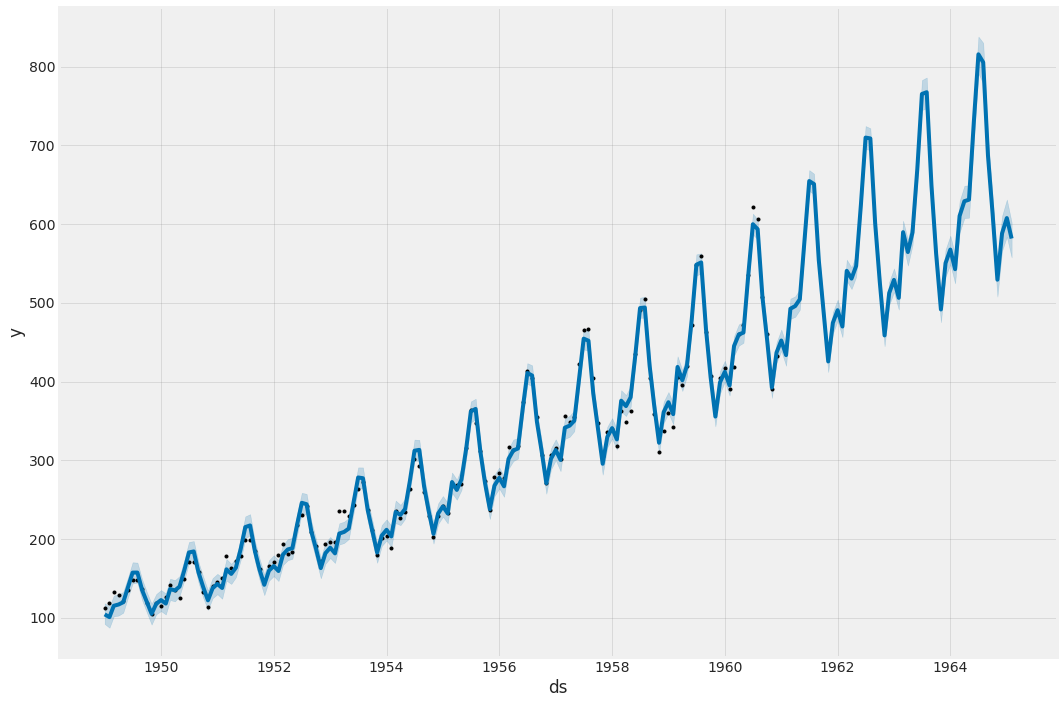

In [35]:
# we keep the default value
m = Prophet(seasonality_mode ='multiplicative')
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.608   0.000325743       50.8423       0.757       0.757      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       501.794   0.000243299       168.853   2.741e-06       0.001      198  LS failed, Hessian reset 
     199       502.731    0.00154449       97.7148           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       503.209   0.000148131       134.069   1.965e-06       0.001      389  LS failed, Hessian reset 
     299       503.416   0.000374679       123.845           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       503.502   2.19353e-05       78.1019   2.837e-07       0.001      564  LS failed, Hessian rese

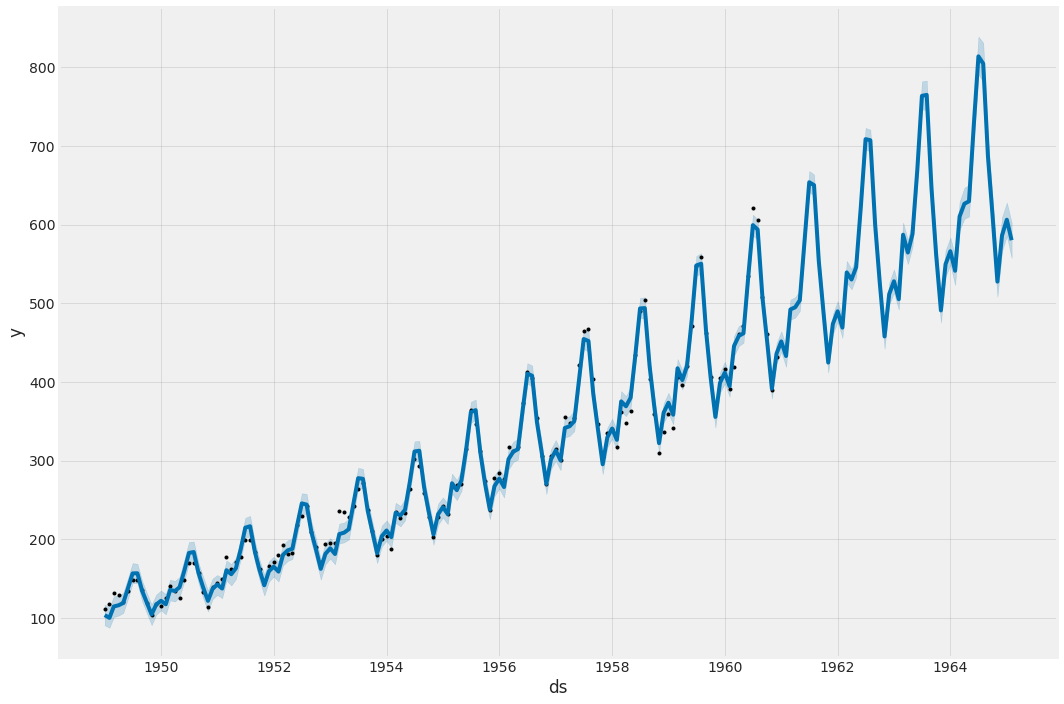

In [36]:
# we reduce the seasonality prior
m = Prophet(seasonality_mode ='multiplicative', seasonality_prior_scale = 1)
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
plt.show()

Last but not least, we can - as we usually ought to - use interval forecast, i.e. have our point estimates combined with uncertainty. By default the parameter `mcmc_samples` is set to 0, so to get the interval around seasonality, you must do full Bayesian sampling; uncertainty around trend can be calculated with Maximum A Posteriori (MAP) estimate.

In [37]:
df = pd.read_csv(pjm_hourly_est)
df['Datetime'] = pd.to_datetime(df['Datetime'])
xdat = df[['Datetime', 'PJME']]
# trim the leading NAs
first_valid = np.where(~np.isnan(xdat['PJME']))[0][0]
xdat = xdat.loc[first_valid:].rename(columns={"Datetime": "ds", "PJME": "y"})
# xdat.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2))
m = Prophet().fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

NameError: name 'pjm_hourly_est' is not defined

What if we switch to Bayesian inference (change `mcmc_samples` to a positive integer)?

In [ ]:
m = Prophet(mcmc_samples = 10).fit(xdat.iloc[:30000])
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

Keep in mind that although PyStan https://pystan.readthedocs.io/en/latest/ is SOTA for MCMC sampling, it still takes some time - especially for long time series. 

<a id="section-four"></a>
# Special days

So we have handled trend and seasonality - but that does not mean everything else belongs with the random error component. There are data points that are not random per se, but can still have impact on the performance of the model:

* public holidays (Christmas, Easter, New Year, Black Friday)
* special events (World Cup) 
* major events like conflict starting or terrorist attacks - when analyzing historical performance of the model, it is frequently useful to remove those
* outliers - this is something of a catch-all category, but frequently possible to identify by inspecting the data. 

The Prophet approach to modeling abnormal days is to provide a custom list of events. We assume the effects are independent, so if e.g. a sports event occurs near public holiday, their effects will be captured separately.

## Holidays

The dataset we will use to test the Prophet functionality around special days is daily count of bike commuters in Oslo https://www.kaggle.com/konradb/norway-bicycles

In [ ]:
bikerides = pd.read_csv(bikerides_day, error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
bikerides.head(5)
# the usual formatting
bikerides = bikerides[['Date', 'Volume']].rename(columns={"Date": "ds", "Volume": "y"})

We start with the fast and easy way of adding holidays: using the built-in list of country holidays:

In [ ]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

I don't speak Norwegian, but a quick visit to Google Translate shows that Christmas is missing - which, in Europe, is typically a rather important public holiday. We will take care of adding it later, for now let's see how well the model is doing out of the box:

In [ ]:
# as before, we create a dataframe holding the dates for the entire forecast horizon - 180 days ahead
future = m.make_future_dataframe(periods=180, freq='D')
# generate the actual forecast 
forecast = m.predict(future)

fig = go.Figure()
# full disclosure: I am changing the plotting style for this one, because I don't know how to overlay the two graphs with the baseline Prophet plotting functionality that served us well up to that point (not to mention the cool functionality of panning/scaling the graph ;-)

fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

Overall the forecast seems directionally ok - but if we zoom a little closer, there are issues:

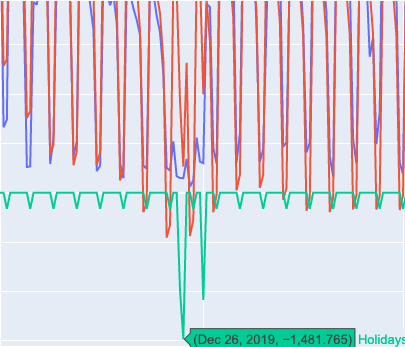

Let's see if we can improve by augmenting the list of holidays: we do that by creating a new dataframe `christmas`, which is subsequently passed as an argument to Prophet. The 'holiday' entry is mostly for interpretation sake, relevant parts are:
* `ds` - so we know when the holiday of interest occurs
* `lower_window` and `upper_window`: those two parameters allow us to incorporate the effect before/after the date, respectively. In our example below `lower_window` equals -1, meaning we anticipate a drop in the number of commuters a day before Christmas, whereas `upper_window` is 7 - with a lot of people taking time off between Christmas and New Year, the bicycle traffic is likely to decrease for approximately a week. 


In [ ]:
christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

m = Prophet(holidays=christmas)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

This does look better:

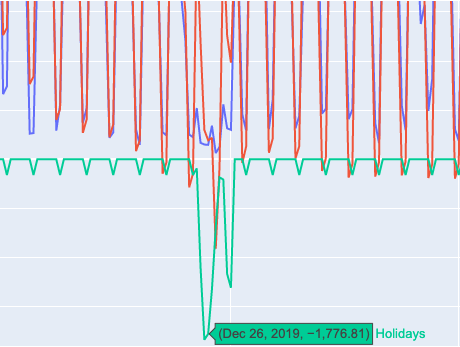

## Outliers

We can use the built-in Prophet functionality to deal with outliers - for the sake of clarity of exposition, we will re-use the example used also in the official documentation, i.e. log of daily count of visits to the Wikipedia page of R language.

In [ ]:
df = pd.read_csv(bikerides_day)
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

The pattern in 2011 does not look plausible (flat line, jump, flat line at a higher level), and those observations are the most likely culprit for the misspecified trend and the resulting bredth of the confidence bands. Prophet allows us to deal with the problem in a very straightforward manner, i.e. by replacing the dubious observations with `None` (not `NaN` - it is an important distinction to keep in mind).

In [ ]:
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future), figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

Another type of situation we may encounter is a few points whose values are extremely off, so as a result the seasonality estimate is impacted.

In [ ]:
df = pd.read_csv(bikerides_day)
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

As before, the simplest solution is to get rid of those points and leave the algorithm to interpolate within the sample:

In [ ]:
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
forecast = m.predict(future)
fig = m.plot(forecast, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')
plt.show()

To summarize: leveraging the Prophet functionality around in-sample interpolation, we can solve issues related to outliers by simply replacing them with `None`s.

<a id="section-five"></a>
# Performance evaluation

Cross validation for time series can be sometimes challenging, but the Prophet approach takes the hassle out of having to create your own function for a rolling forecast. We utilize the `cross_validation` function: the parameters to specify are the forecast horizon `horizon` and (optionally) size of the initial training period `initial` and the spacing between cutoff dates `period`. By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

       

In [ ]:
df_cv = cross_validation(m, initial = '1000 days', period = '30 days', horizon='30 days')

The output of cross_validation is a dataframe where for $cutoff$ (last timepoint in the training set) we get a number of values:
* $ds$ is the timepoint in test set
* $y$ is the true value at $ds$
* $yhat\_lower$ and $yhat\_upper$ are the lower and upper ends of the condifence interval, respectively


In [ ]:
df_cv.head(10)

While informative, the object created with `cross_validation` contains an abundance of information. This can be summarized in a more succinct manner by aggregating to yield performance metrics:

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

The values from the `cross_validation` objects are aggregated for each horizon and different metrics are calculated.


<a id="section-six"></a>
# Full pipeline

We are in a position to combine all the building blocks - we will use the Superstore dataset (a version can be found here: https://www.kaggle.com/bravehart101/sample-supermarket-dataset).


In [ ]:
df = pd.read_excel(Sample_Superstore)
df = df.loc[df['Category'] == 'Furniture']
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID',
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region',
        'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Order Date')
df = df.groupby('Order Date')['Sales'].sum().reset_index()
# Prophet-friendly format
df.rename(columns={"Order Date": "ds", "Sales": "y"}, inplace = True)

In the previous module we aggregated the dataset to monthly frequency - some observations were missing and ARIMA does not have a straightforward method of dealing with that (interpolation in time series is a serious topic, deserving its own module probably). Prophet does not suffer from the same limitation, so we stay at daily frequency. 

What does our series look like?


In [ ]:
df.set_index('ds').plot(figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

What is the time range we are dealing with?

In [ ]:
min(df['ds']), max(df['ds'])

With four complete cycles present, we can keep the last three months of 2017 as validation and use the rest of the data for training:

In [ ]:
df_train = df.loc[df['ds'] < '2017-10-01']
df_valid = df.loc[df['ds'] >= '2017-10-01']
print(df_train.shape, df_valid.shape)

Next step is specifying the form of our model - we can combine this step with hyperparameter tuning. In order to keep the running time of this notebook within reasonable limits, the possible parameter ranges to a bare minimum needed to demonstrate the functionality (in a real application the only real limit is your patience).

In [ ]:
param_grid = {  
    # tuning those parameters can potentially improve the performance of our model
    'changepoint_prior_scale': [0.001, 0.1],
#    'seasonality_prior_scale': [0.01, 1.0],
#    'holidays_prior_scale': [0.01, 0.1],
    'seasonality_mode': ['additive', 'multiplicative'],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []
# Quick peek at what our combinations look like
all_params

In [ ]:
for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial = '100 days', period = '30 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

With the tuned parameters available we can proceed to setup the complete model - as mentioned before, the parameters can included in the tuning part can be left at default values (`auto` for `yearly_seasonality` is automatically set to `True` if there are multiple years in the data etc):

In [ ]:
m = Prophet(**params)
m.add_country_holidays(country_name='US')
m.fit(df_train)

Model component inspection:

In [ ]:
future = m.make_future_dataframe(periods=92, freq='D')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

By default, the `forecast` dataframe contains an abundance of information, including point/upper/lower estimates of the contribution made to the forecast by the trend component, different seasonalities and each holiday defined in the model:

In [ ]:
forecast.columns

While interesting if you want to examine every component in detail, for this example we will focus on the point forecast and the associated confidence band:

In [ ]:
xfor = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2017-10-01' ]
xfor.head(10)

In [ ]:
# we combine the forecast dataframe with the original test data
# we use a left outer join because of the missing observations in the original data
xfor = pd.merge(left = xfor, right = df, on = 'ds', how = 'left')

In [ ]:
xfor.head(10)

In [ ]:
colors = ['#BB0000' , '#0000BB', '#0000BB', 'green']
xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color = colors, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '')

While there is definitely space for improvement - the model does not capture the magnitude of the variations, and the associated confidence interval is rather broad - this example demonstrates that with minimal effort, we can use Prophet to model time series in a fast and intrepretable manner.

<a id="section-seven"></a>
# Using covariates

It is not a terribly common situation, but sometimes we get lucky and there is extra information we can use to improve the quality of our forecast: stable weather prediction, or some economic indicators made known earlier than others. In this section we demonstrate how this functionality works in Prophet. First thing we do, we load our dataset (recorded performance of the teams in the Autonomous Greenhouse Challenge) - we will focus on the subset of the original problem, namely how to predict the air temperature based on the settings in the greenhouse environment. The original dataset can be found here: https://www.kaggle.com/piantic/autonomous-greenhouse-challengeagc-2nd-2019.


In [ ]:
xdat = pd.read_csv(GreenhouseClimate1)
xdat.head(3)

That's a lot of columns, and we will get to that in a moment - but first, we need to do something about the timestamp. The original data was sampled every 5 minutes and stored in Excel format, which is why need to adjust the epoch start:

In [ ]:
xdat['time'] = pd.to_datetime(xdat['time'], unit = 'D', origin = "1899-12-30")
xdat.head(3)

That's better. Reading through the Readme in the description of the original dataset, we can identify the variables that are available going forward. Since only those are useful as external covariates potentially helpful with our forecast, we can subset the dataframe:

In [ ]:
# timestamp and target variable
list1 = ['time', 'Tair']
# candidate variables for external regressors improving the forecast
list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
        'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
        't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
        'int_blue_sp', 'int_red_sp', 'int_farred_sp',
        'int_white_sp']
xdat = xdat[list1 + list2]

A realistic lookahead period might be 24 hours - we can either stick to the original resolution of the data and forecast 24 * 12 = 288 steps ahead, or downsample the data to hourly frequency. Since all the variables are numerical, we just take their average values within each hour:

In [ ]:
xdat2 = xdat.resample('H', on = 'time').mean().reset_index()[list1 + list2]

In [ ]:
# let's quickly check for missing values - Prophet can handle those (by interpolation), but they are not useful in terms of predictive value
np.isnan(xdat2[['Tair'] + list2]).describe()

In [ ]:
xdat2.dropna(subset = ['Tair'], inplace = True)
# what does our data look like after preparation? 
xdat2['Tair'][0:1000].plot()

This looks ready for applying Prophet: as before, we start by formatting the dataframe into the format expected by the algorithm

In [ ]:
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})

The only real adjustment we need is disabling weekly seasonality. By default, Prophet fits any seasonal pattern with enough data - annual pattern will not be fitted since we only have 6 months worth of data, hourly is automatic, but weekly makes no sense for a physical phenomenon (there is no reason to expect temperature to be dependent on day of the week).

In [ ]:
m = Prophet(weekly_seasonality=False, interval_width = 0.95)
m.fit(df)
# build the forecast the usual way
future = m.make_future_dataframe(periods= 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast, figsize=(CFG.img_dim1, CFG.img_dim2))
print()

In [ ]:
# Calculate the cross-validation performance
df_cv = cross_validation(m,initial = '3700 hours', period = '24 hours', horizon = '24 hours')
df_p1 = performance_metrics(df_cv)
df_p1.head(10)

This gives us an idea of the model performance in a "vanilla" version. Let's add the covariates:

In [ ]:
# we need to drop NA - Prophet can handle missing values in the target, but not in the explanatory variables 
# (and neither does the recursive feature elimination routine RFECV)
xdat2 = xdat2.dropna()
# for the sake of demonstration, we keep it simple - so Ridge is good enough to check the importance of a variable for our target prediction
estimator = Ridge()
# the elimination is a bit aggressive :-)
selector =  RFECV(estimator, step=10, cv=10)
selector = selector.fit(xdat2[list2], xdat2['Tair'])
to_keep = xdat2[list2].columns[selector.support_]
print(to_keep)

In [ ]:
# We can now fit our model with the regressors included
df = xdat2[['time', 'Tair']].rename(columns={"time": "ds", "Tair": "y"})
m = Prophet(weekly_seasonality=False, interval_width = 0.95)

# add the regressors to the dataframe holding the data
for f in to_keep:    
    df[f] = xdat2[f]
    m.add_regressor(f)

# the rest proceeds as before. 
m.fit(df)

We want to compare the "vanilla" and extended models, to we conduct the validation in exact same manner

In [ ]:
# we repeat the same evaluation tactic as before
df_cv = cross_validation(m, initial = '3700 hours', period = '24 hours', horizon='24 hours')
df_p2 = performance_metrics(df_cv)
df_p2.head(3)

How do the two models compare ?

In [ ]:
comparison = pd.DataFrame()
comparison['raw'] = df_p1.mean(axis = 0)[1:]
comparison['covariates'] = df_p2.mean(axis = 0)[1:]
print(comparison)

As you can see from the above table, with minimal effort of adding the covariates we can improve the performance of the model wrt all the relevant metrics. 

<a id="section-seven"></a>
# Neural Prophet

If an algorithmic approach works well in ML, the question worth asking is frequently: will it get better with Deep Learning? The answer, surprisingly often ;-) is affirmative - and that was the core idea behind Neural Prophet. The changes compared to the "basic" Prophet are given on the project website https://neuralprophet.com/html/index.html:

* Gradient Descent for optimisation via using PyTorch as the backend.

* Modelling autocorrelation of time series using AR-Net

* Modelling lagged regressors using a sepearate Feed-Forward Neural Network.

* Configurable non-linear deep layers of the FFNNs.

* Tuneable to specific forecast horizons (greater than 1).

* Custom losses and metrics.

The core addition from a conceptual point of view seems to be the AR-Net - for those interested, the original paper can be found here: https://www.arxiv-vanity.com/papers/1911.12436/. 

Is Neural Prophet really better? As the Russian proverb says "trust, but verify", so let's find out! The first thing we need to do is actually install Neural Prophet - as of the time of writing this notebook, the package is not part of the Kaggle Python image.


In [ ]:
# !pip install neuralprophet

In honor of the classic Dead Kennedys song, we will use the data on energy consumption in the U.S. state of California:

In [ ]:
# a necessary dependency for working with xlsx files in pandas
# !pip install openpyxl

In [ ]:
# read the raw *daily* data
df = pd.read_excel(Region_CAL, sheet_name='Published Daily Data', header=0, usecols = ['Local date', 'D'])
# format to Prophet convention - both Prophet and Neural Prophet adheres to it
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])
df.plot(x="ds",y="y")

In [ ]:
# We split the data into training / validation (= last 365 days)
df_train, df_valid = df.iloc[:-365], df.iloc[-365:]

Fitting the basic Prophet model and generating a forecast is a familiar routine by now:

In [ ]:
m_vanilla = Prophet()
m_vanilla.fit(df_train)
future = m_vanilla.make_future_dataframe(periods=365)
forecast_vanilla = m_vanilla.predict(future)
m_vanilla.plot(forecast_vanilla, figsize=(CFG.img_dim1, CFG.img_dim2), xlabel = '', ylabel = 'total nof cases')
print()

In [ ]:
m_vanilla.plot_components(forecast_vanilla, figsize=(CFG.img_dim1, CFG.img_dim2)); print()

Neural Prophet requires minimal adjustments to the syntax:

In [ ]:
pd.options.mode.chained_assignment = None
m_neural = NeuralProphet()
metrics = m_neural.fit(df_train, freq="D")

In [ ]:
df_future = m_neural.make_future_dataframe(df_train, periods=365)
forecast_neural = m_neural.predict(df_future)
fig_forecast = m_neural.plot(forecast_neural, figsize=(CFG.img_dim1, CFG.img_dim2))  # create plots

In [ ]:
fig_components = m_neural.plot_components(forecast_neural, figsize=(CFG.img_dim1, CFG.img_dim2))

What about the actual predicted values?



In [ ]:
df_valid['forecast_vanilla'] = forecast_vanilla.yhat.tail(365).values
df_valid['forecast_neural'] = forecast_neural.yhat1.values

In [ ]:
def my_mse(x,y):
    return np.round(np.sqrt(mse(x, y)),2)


def my_mae(x,y):
    return np.round(np.sqrt(mae(x, y)),2)

In [ ]:
df_valid.dropna(inplace = True)

err1 = my_mse(df_valid['y'], df_valid['forecast_vanilla'])
err2 = my_mse(df_valid['y'], df_valid['forecast_neural'])

print('MSE vanilla: ' + str(err1))
print('MSE neural : ' + str(err2))

err1 = my_mae(df_valid['y'], df_valid['forecast_vanilla'])
err2 = my_mae(df_valid['y'], df_valid['forecast_neural'])

print('   ')
print('MAE vanilla: ' + str(err1))
print('MAE neural : ' + str(err2))

As we can see above, even with default settings (no lags, only the AR-Net used to model serial dependence) the **Neural Prophet outperforms the non-deep version**.


This concludes the notebook dedicated to Prophet - next, we will have a look at a framework that integrates multiple models encountered so far. Stay tuned!
